
# Regression Case Study: Student Performance Prediction with Regression Models

**Dataset:** `Student_Performance.csv`  
**Task:** Predict student performance using regression  
**Models:**  
- Linear Regression  
- Polynomial Regression (degree 2, 3, 4)  
**Regularization:** **Not used** (as requested)

---

## What you will do in this notebook

We evaluate regression models under **three scenarios**:

### Scenario A — Remove *Extracurricular Activities*
- Drop the column `Extracurricular Activities`
- 70% / 30% random Train/Test split
- Train + evaluate models

### Scenario B — Train separately for each group
- Train only on `Extracurricular Activities = "Yes"`
- Train only on `Extracurricular Activities = "No"`

### Scenario C — One-hot encode *Extracurricular Activities*
- Replace `Extracurricular Activities` with two columns:
  - `Extra_Yes` and `Extra_No`

---

## Evaluation Metrics (Train & Test)

For each model, we report:
- Mean Squared Error (**MSE**)
- Mean Absolute Error (**MAE**)
- Coefficient of Determination (**R²**)


In [3]:

# ============================================================
# Imports
# ============================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt



## 1) Load the dataset and inspect basic information

In this section, we load the dataset into a pandas DataFrame and perform a **basic sanity check** before building any models.

### What this code does
- **Loads the CSV file** into a pandas DataFrame (`df`)
- Prints the **shape** of the dataset:
  - number of rows = number of samples (students)
  - number of columns = number of features (variables)
- Prints the **column names** to understand what information is available
- Displays the **first few rows** using `head()` to preview the data format and values
- Shows **summary statistics** using `describe()`:
  - for numeric columns: mean, standard deviation, min/max, quartiles, etc.
  - for non-numeric columns: count, unique values, most common value, etc.
- Checks for **missing values** in each column

### Why this matters
Machine learning models depend heavily on clean and well-structured data.  
Before training any regression model, we must confirm:
- the target column exists (here: **Performance Index**)
- columns have reasonable values and types
- there are no unexpected missing values that could break model training


In [5]:

# ============================================================
# Load dataset
# ============================================================

DATA_PATH = "Student_Performance.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

display(df.head(20))

print("\nSummary statistics:")
display(df.describe(include="all"))

print("\nMissing values per column:")
display(df.isna().sum())


Shape: (10000, 6)

Columns:
['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index']


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
5,3,78,No,9,6,61.0
6,7,73,Yes,5,6,63.0
7,8,45,Yes,4,6,42.0
8,5,77,No,8,2,61.0
9,4,89,No,4,0,69.0



Summary statistics:


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,No,NaN,NaN,NaN
freq,NaN,NaN,5052,NaN,NaN,NaN
mean,4.992900,69.445700,NaN,6.530600,4.583300,55.224800
std,2.589309,17.343152,NaN,1.695863,2.867348,19.212558
min,1.000000,40.000000,NaN,4.000000,0.000000,10.000000
25%,3.000000,54.000000,NaN,5.000000,2.000000,40.000000
50%,5.000000,69.000000,NaN,7.000000,5.000000,55.000000
75%,7.000000,85.000000,NaN,8.000000,7.000000,71.000000



Missing values per column:


,0
Hours Studied,0
Previous Scores,0
Extracurricular Activities,0
Sleep Hours,0
Sample Question Papers Practiced,0
Performance Index,0


## 2) Utility functions

In below, we will run **multiple regression experiments** (dropping a feature, splitting by groups, one-hot encoding, etc.).  
To keep our notebook clean and avoid copy-pasting the same code many times, we define a few **helper functions**.

These functions handle the most common steps in any supervised learning workflow:
1. Preparing features **X** and target **y**
2. Splitting data into **train** and **test**
3. Training linear and polynomial regression models
4. Computing evaluation metrics
5. Visualizing predicted vs actual values on the test set
6. Printing a simplified version of the learned regression equation

---

### What each function does

- **`prepare_xy(df_in)`**  
  Removes rows with missing values and splits the dataset into:
  - **X** = input features (all columns except the target)  
  - **y** = target variable (here: `Performance Index`)

- **`split_data(X, y)`**  
  Performs a **70% / 30% train-test split** using a fixed `random_state` so that results are reproducible.

- **`compute_metrics(y_true, y_pred)`**  
  Computes three standard regression evaluation metrics:
  - **MSE (Mean Squared Error):** penalizes large errors more strongly  
  - **MAE (Mean Absolute Error):** average absolute prediction error  
  - **R² (Coefficient of Determination):** measures how well the model explains the variance in the data

- **`print_fitted_equation(...)`**  
  Prints the fitted regression model equation using the learned coefficients.  
  For polynomial regression, the number of terms can become very large, so the notebook prints only the **top terms** with the largest coefficient magnitude.

- **`plot_actual_vs_predicted_test(...)`**  
  Creates a scatter plot for the **test set** showing:
  - **Actual values** (blue circles)
  - **Predicted values** (red x’s)  
  This helps visually compare how close the predictions are to real values.

- **`run_models_and_evaluate(...)`**  
  This is the main driver function that runs everything for a given scenario:
  - Trains **Linear Regression** and **Polynomial Regression (degrees 2, 3, 4)**
  - Evaluates **train and test** performance using MSE, MAE, and R²
  - Prints fitted equation (top terms)
  - Generates test-set scatter plots
  - Returns a clean results table for easy comparison

---

✅ After this section, the rest of the notebook becomes much shorter and easier to read, because each scenario can reuse these helper functions.


In [ ]:
# ============================================================
# Utility functions
# ============================================================

TARGET_COL = "Performance Index"
EXTRA_COL = "Extracurricular Activities"

def prepare_xy(df_in, target_col=TARGET_COL):
    """Drop missing rows, split into X and y."""
    df_clean = df_in.dropna().copy()
    X = df_clean.drop(columns=[target_col])
    y = df_clean[target_col]
    return X, y

def split_data(X, y, test_size=0.30, random_state=42):
    """70/30 random train-test split."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def compute_metrics(y_true, y_pred):
    """Return MSE, MAE, R^2."""
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R^2": r2_score(y_true, y_pred),
    }

def _get_linear_parts(model, input_feature_names):
    """Extract (intercept, coefficients, feature_names) from either:
       - LinearRegression
       - Pipeline(PolynomialFeatures -> LinearRegression)
    """
    # Plain LinearRegression
    if isinstance(model, LinearRegression):
        intercept = float(model.intercept_)
        coefs = np.array(model.coef_).ravel()
        feat_names = np.array(list(input_feature_names))
        return intercept, coefs, feat_names

    # Polynomial pipeline
    if hasattr(model, "named_steps") and "poly" in model.named_steps and "lr" in model.named_steps:
        poly = model.named_steps["poly"]
        lr = model.named_steps["lr"]

        feat_names = poly.get_feature_names_out(input_features=list(input_feature_names))
        intercept = float(lr.intercept_)
        coefs = np.array(lr.coef_).ravel()
        return intercept, coefs, np.array(feat_names)

    raise ValueError("Unsupported model type for equation printing.")

def print_fitted_equation(model, input_feature_names, target_name=TARGET_COL, top_k_terms=15):
    """Print a readable fitted equation.

    For polynomial models, the number of terms can become very large,
    so we print only the TOP-K terms by absolute coefficient magnitude.
    """
    intercept, coefs, feat_names = _get_linear_parts(model, input_feature_names)

    # Sort by absolute coefficient magnitude
    order = np.argsort(np.abs(coefs))[::-1]
    order = order[:min(top_k_terms, len(coefs))]

    terms = []
    for idx in order:
        terms.append(f"({coefs[idx]:+.4f}) * {feat_names[idx]}")

    eq = f"{target_name} = {intercept:.4f} " + " ".join(terms)

    print("\n--- Fitted Model Equation (Top Terms) ---")
    print(eq)
    if len(coefs) > top_k_terms:
        print(f"(Showing top {top_k_terms} terms out of {len(coefs)} total terms.)")

def plot_actual_vs_predicted_test(y_test, y_pred, title, max_points=300):
    """Scatter plot of Actual vs Predicted values on the TEST set.

    We plot both series against a sample index, using:
    - Actual: blue circles
    - Predicted: red x's

    If test set is large, we randomly sample up to max_points points for readability.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    n = len(y_test)
    if n > max_points:
        rng = np.random.default_rng(0)
        sel = rng.choice(n, size=max_points, replace=False)
        y_test = y_test[sel]
        y_pred = y_pred[sel]

    x = np.arange(len(y_test))

    plt.figure(figsize=(12, 4))
    plt.scatter(x, y_test, marker="o", alpha=0.8, label="Actual (Test)")
    plt.scatter(x, y_pred, marker="x", alpha=0.8, label="Predicted (Test)")
    plt.title(title)
    plt.xlabel("Test sample index (subset)")
    plt.ylabel(TARGET_COL)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()

def run_models_and_evaluate(df_in, scenario_name, degrees=(1, 2, 3, 4),
                            target_col=TARGET_COL, test_size=0.30, random_state=42,
                            show_equation=True, show_plots=True, top_k_terms=15):
    """Train/evaluate linear (deg=1) + polynomial regression models.

    Returns a DataFrame of metrics.
    Also prints fitted equations and scatter plots (test set) for each model.
    """
    X, y = prepare_xy(df_in, target_col=target_col)
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)

    rows = []

    for deg in degrees:
        if deg == 1:
            model = LinearRegression()
            model_name = "Linear Regression"
        else:
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
                ("lr", LinearRegression())
            ])
            model_name = f"Polynomial Regression (degree={deg})"

        # Fit model
        model.fit(X_train, y_train)

        # Predict
        yhat_train = model.predict(X_train)
        yhat_test  = model.predict(X_test)

        # Metrics
        train_m = compute_metrics(y_train, yhat_train)
        test_m  = compute_metrics(y_test, yhat_test)

        # Report equation + plot (TEST set)
        print("\n============================================================")
        print(f"Scenario: {scenario_name}")
        print(f"Model: {model_name}")
        print("============================================================")

        if show_equation:
            print_fitted_equation(
                model=model,
                input_feature_names=X_train.columns,
                target_name=target_col,
                top_k_terms=top_k_terms
            )

        if show_plots:
            plot_actual_vs_predicted_test(
                y_test=y_test,
                y_pred=yhat_test,
                title=f"{scenario_name} — {model_name} (Test Set: Actual vs Predicted)"
            )

        rows.append({
            "Scenario": scenario_name,
            "Model": model_name,
            "Train MSE": train_m["MSE"],
            "Train MAE": train_m["MAE"],
            "Train R^2": train_m["R^2"],
            "Test MSE": test_m["MSE"],
            "Test MAE": test_m["MAE"],
            "Test R^2": test_m["R^2"],
            "Train size": len(X_train),
            "Test size": len(X_test),
        })

    return pd.DataFrame(rows)



## Scenario A — Remove `Extracurricular Activities` and train models

In this scenario, we **remove** the column **`Extracurricular Activities`** entirely and train regression models using only the remaining features.

### What we are testing here
We want to answer the question:

✅ **Can we predict student performance accurately without knowing whether the student participates in extracurricular activities?**

This gives us a useful baseline model that uses only the **other numeric/continuous features** in the dataset.

### What the code does
- Use the DataFrame `df_no_extra` that **dropped** the column `Extracurricular Activities`
- Trains and evaluates the following models using a **70% / 30% random train-test split**:
  - **Linear Regression**
  - **Polynomial Regression** (degree **2**, **3**, and **4**)
- Reports **Train and Test** metrics:
  - **MSE**, **MAE**, and **R²**
- Prints the fitted model equation (top coefficient terms)
- Plots **Actual vs Predicted** values for the **test set**

✅ The output table (`results_A`) will help us compare whether higher-degree polynomial models improve performance over basic linear regression.



Scenario: A: Remove Extracurricular Activities
Model: Linear Regression

--- Fitted Model Equation (Top Terms) ---
Performance Index = -33.5369 (+2.8592) * Hours Studied (+1.0157) * Previous Scores (+0.4765) * Sleep Hours (+0.1893) * Sample Question Papers Practiced


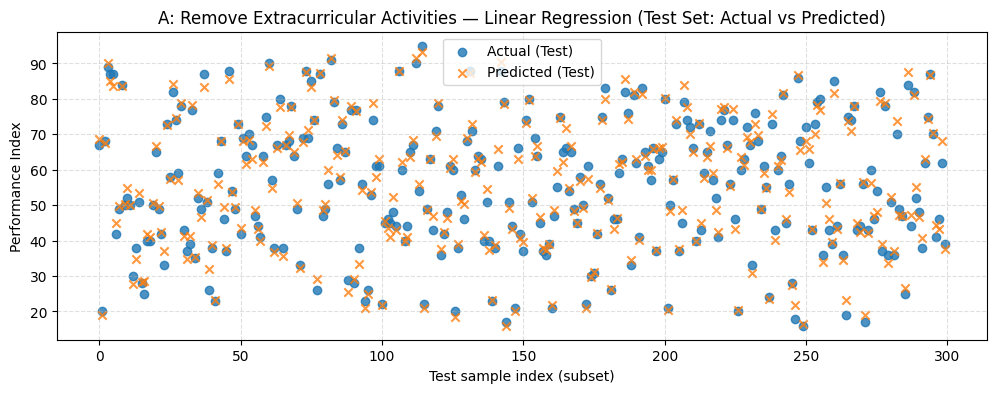


Scenario: A: Remove Extracurricular Activities
Model: Polynomial Regression (degree=2)

--- Fitted Model Equation (Top Terms) ---
Performance Index = -32.5924 (+2.7994) * Hours Studied (+1.0256) * Previous Scores (+0.1457) * Sleep Hours (+0.1358) * Sample Question Papers Practiced (+0.0208) * Sleep Hours^2 (+0.0094) * Sleep Hours Sample Question Papers Practiced (+0.0038) * Hours Studied^2 (+0.0015) * Hours Studied Sleep Hours (+0.0009) * Hours Studied Sample Question Papers Practiced (-0.0002) * Sample Question Papers Practiced^2 (-0.0002) * Previous Scores Sample Question Papers Practiced (+0.0001) * Previous Scores Sleep Hours (+0.0001) * Hours Studied Previous Scores (-0.0001) * Previous Scores^2


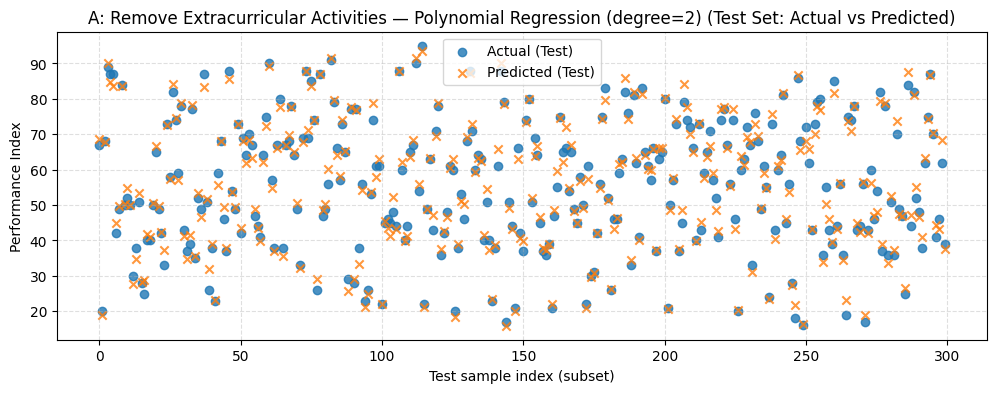


Scenario: A: Remove Extracurricular Activities
Model: Polynomial Regression (degree=3)

--- Fitted Model Equation (Top Terms) ---
Performance Index = -41.3430 (+3.1045) * Hours Studied (+1.6422) * Sleep Hours (+1.2737) * Previous Scores (-0.1673) * Sleep Hours^2 (-0.1103) * Sample Question Papers Practiced (+0.0863) * Sleep Hours Sample Question Papers Practiced (+0.0404) * Sample Question Papers Practiced^2 (+0.0401) * Hours Studied Sleep Hours (-0.0171) * Previous Scores Sleep Hours (-0.0157) * Hours Studied Sample Question Papers Practiced (-0.0121) * Hours Studied Previous Scores (+0.0085) * Hours Studied^2 (+0.0084) * Sleep Hours^3 (-0.0038) * Sleep Hours^2 Sample Question Papers Practiced (-0.0033) * Hours Studied Sleep Hours Sample Question Papers Practiced
(Showing top 15 terms out of 34 total terms.)


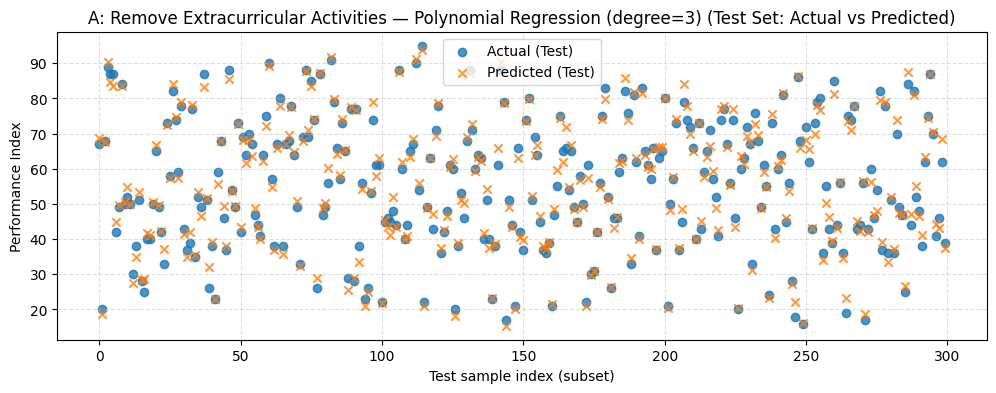


Scenario: A: Remove Extracurricular Activities
Model: Polynomial Regression (degree=4)

--- Fitted Model Equation (Top Terms) ---
Performance Index = -53.4320 (+6.6148) * Sleep Hours (+3.9892) * Hours Studied (+1.4942) * Previous Scores (-0.8528) * Sample Question Papers Practiced (-0.6697) * Sleep Hours^2 (-0.4010) * Hours Studied Sleep Hours (+0.3429) * Sleep Hours Sample Question Papers Practiced (+0.1385) * Sample Question Papers Practiced^2 (-0.1286) * Previous Scores Sleep Hours (-0.0950) * Hours Studied Sample Question Papers Practiced (-0.0495) * Sleep Hours^2 Sample Question Papers Practiced (+0.0383) * Hours Studied^2 (+0.0334) * Hours Studied Sleep Hours^2 (+0.0302) * Hours Studied^2 Sleep Hours (-0.0207) * Hours Studied Sleep Hours Sample Question Papers Practiced
(Showing top 15 terms out of 69 total terms.)


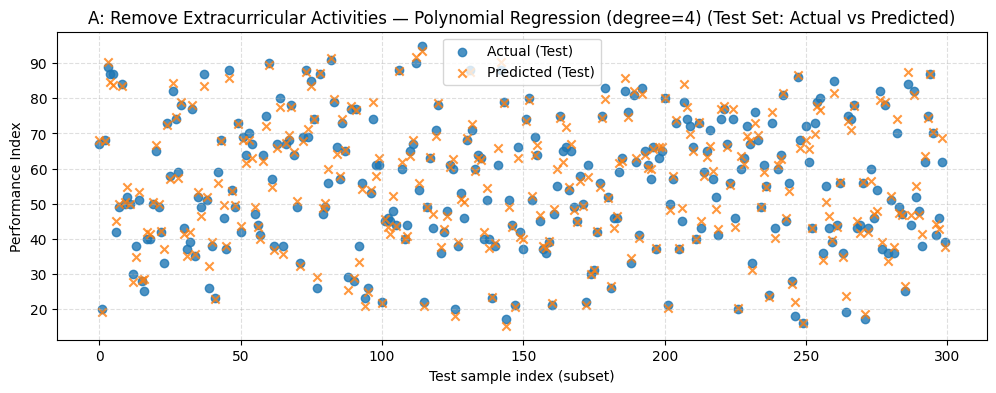

,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,A: Remove Extracurricular Activities,Linear Regression,4.277996,1.641751,0.988393,4.181380,1.630177,0.988701,7000,3000
1,A: Remove Extracurricular Activities,Polynomial Regression (degree=2),4.272026,1.640938,0.988409,4.188852,1.630133,0.988681,7000,3000
2,A: Remove Extracurricular Activities,Polynomial Regression (degree=3),4.257813,1.638355,0.988448,4.184446,1.627886,0.988693,7000,3000
3,A: Remove Extracurricular Activities,Polynomial Regression (degree=4),4.242087,1.635859,0.988490,4.208458,1.632857,0.988628,7000,3000


In [ ]:

# ============================================================
# Scenario A: Drop extracurricular activities column
# ============================================================

df_no_extra = df.drop(columns=[EXTRA_COL]).copy()

results_A = run_models_and_evaluate(
    df_no_extra,
    scenario_name="A: Remove Extracurricular Activities",
    degrees=(1, 2, 3, 4),
    show_equation=True,
    show_plots=True,
    top_k_terms=15
)

display(results_A)


## Scenario B — Train separate models for two groups (Yes vs No)

In this scenario, we **split the dataset into two groups** based on the categorical feature:

- `Extracurricular Activities = "Yes"`
- `Extracurricular Activities = "No"`

Then, we train and evaluate regression models **separately** for each group.

---

### Why do this?
Instead of treating extracurricular participation as an input feature, we are asking:

✅ **Does the relationship between the other features and performance change depending on the group?**

For example, it is possible that the same feature (like study time or sleep time) affects performance differently for students who participate in extracurricular activities vs those who do not.

---

### What the code does
- First, it cleans the values in the `Extracurricular Activities` column using:
  - `.astype(str)` → ensures everything is treated as text  
  - `.str.strip()` → removes leading/trailing spaces  
  - `.str.lower()` → converts to lowercase so `"Yes"`, `" yes "`, `"YES"` all match correctly  
- Creates two new DataFrames:
  - `df_yes`: only students with `"Yes"`  
  - `df_no`: only students with `"No"`  
- Drops the `Extracurricular Activities` column from each subset because inside each group it becomes a **constant column** (it provides no useful variation for prediction)
- Runs the same four models (with the same 70/30 split) on each group:
  - **Linear Regression**
  - **Polynomial Regression** (degrees **2**, **3**, **4**)
- Prints equations, test-set prediction plots, and evaluation metrics
- Combines results into one table (`results_B`) so we can compare performance across groups

✅ The combined results table helps us see whether model behavior and accuracy are different for the `"Yes"` group vs the `"No"` group.



Scenario: B1: Extracurricular Activities = "Yes"
Model: Linear Regression

--- Fitted Model Equation (Top Terms) ---
Performance Index = -33.5024 (+2.8732) * Hours Studied (+1.0186) * Previous Scores (+0.4763) * Sleep Hours (+0.1876) * Sample Question Papers Practiced


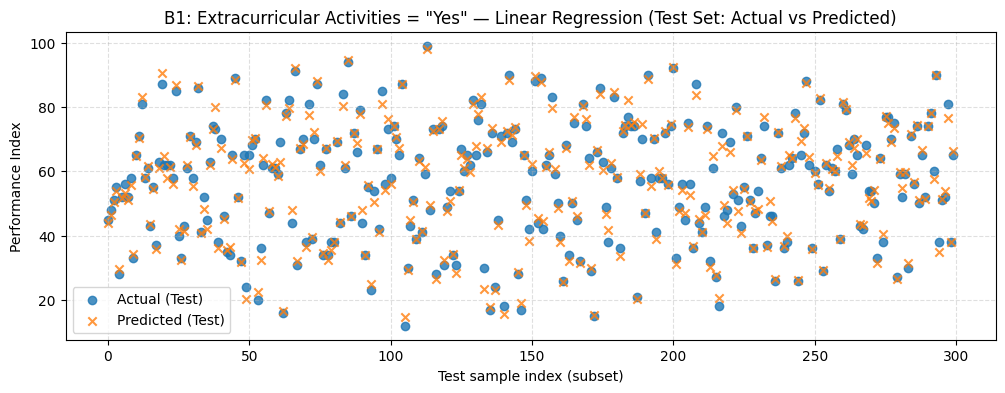


Scenario: B1: Extracurricular Activities = "Yes"
Model: Polynomial Regression (degree=2)

--- Fitted Model Equation (Top Terms) ---
Performance Index = -33.5471 (+2.7598) * Hours Studied (+1.0339) * Previous Scores (+0.4273) * Sleep Hours (+0.1356) * Sample Question Papers Practiced (+0.0132) * Hours Studied^2 (+0.0057) * Sleep Hours^2 (-0.0037) * Hours Studied Sleep Hours (+0.0027) * Hours Studied Sample Question Papers Practiced (+0.0009) * Sample Question Papers Practiced^2 (+0.0005) * Previous Scores Sample Question Papers Practiced (-0.0003) * Sleep Hours Sample Question Papers Practiced (-0.0001) * Previous Scores^2 (-0.0001) * Hours Studied Previous Scores (-0.0001) * Previous Scores Sleep Hours


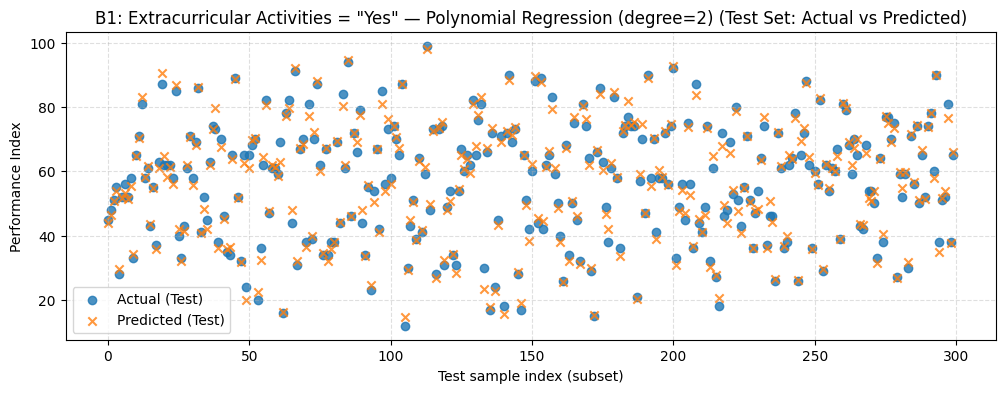


Scenario: B1: Extracurricular Activities = "Yes"
Model: Polynomial Regression (degree=3)

--- Fitted Model Equation (Top Terms) ---
Performance Index = -43.8523 (+4.3587) * Hours Studied (+3.0516) * Sleep Hours (+1.1749) * Previous Scores (-0.3556) * Sleep Hours^2 (-0.2053) * Hours Studied Sleep Hours (-0.1988) * Sample Question Papers Practiced (+0.0294) * Sleep Hours Sample Question Papers Practiced (-0.0272) * Hours Studied Previous Scores (-0.0158) * Hours Studied Sample Question Papers Practiced (+0.0143) * Sleep Hours^3 (+0.0138) * Sample Question Papers Practiced^2 (+0.0116) * Hours Studied Sleep Hours^2 (+0.0097) * Hours Studied^2 (+0.0083) * Previous Scores Sample Question Papers Practiced (+0.0061) * Sleep Hours Sample Question Papers Practiced^2
(Showing top 15 terms out of 34 total terms.)


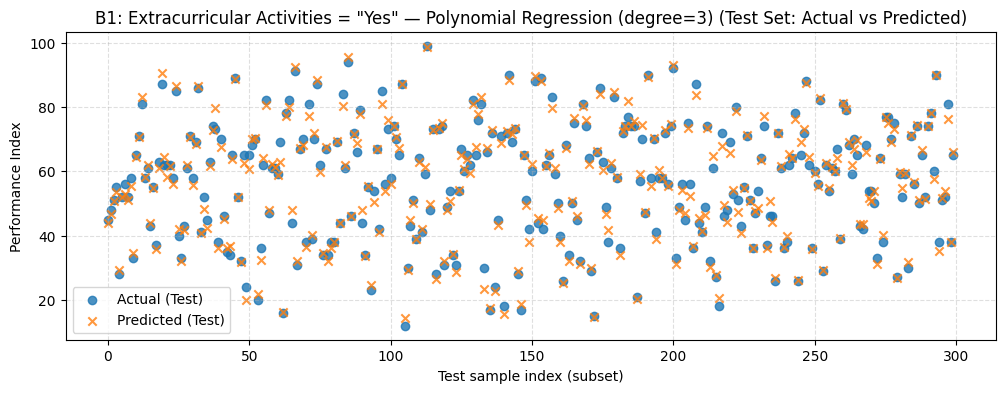


Scenario: B1: Extracurricular Activities = "Yes"
Model: Polynomial Regression (degree=4)

--- Fitted Model Equation (Top Terms) ---
Performance Index = -54.4386 (+3.6216) * Hours Studied (+2.0758) * Previous Scores (+0.9152) * Sleep Hours^2 (+0.6319) * Sleep Hours (-0.5479) * Hours Studied Sleep Hours (-0.5260) * Sample Question Papers Practiced (+0.3688) * Sleep Hours Sample Question Papers Practiced (-0.1667) * Sleep Hours^2 Sample Question Papers Practiced (+0.1526) * Sample Question Papers Practiced^2 (-0.1504) * Previous Scores Sleep Hours (-0.1044) * Hours Studied Sample Question Papers Practiced (+0.0814) * Hours Studied^2 Sleep Hours (+0.0612) * Hours Studied Sleep Hours Sample Question Papers Practiced (+0.0567) * Hours Studied Previous Scores (-0.0555) * Sleep Hours^3
(Showing top 15 terms out of 69 total terms.)


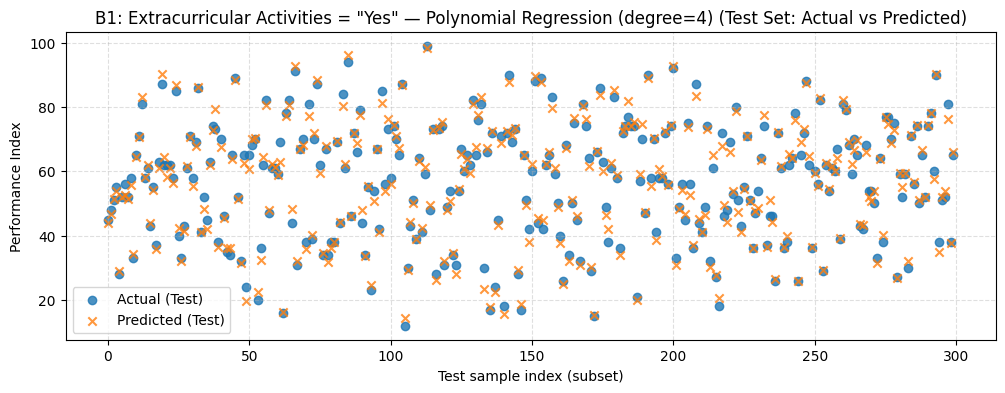


Scenario: B2: Extracurricular Activities = "No"
Model: Linear Regression

--- Fitted Model Equation (Top Terms) ---
Performance Index = -33.9105 (+2.8330) * Hours Studied (+1.0160) * Previous Scores (+0.4905) * Sleep Hours (+0.2018) * Sample Question Papers Practiced


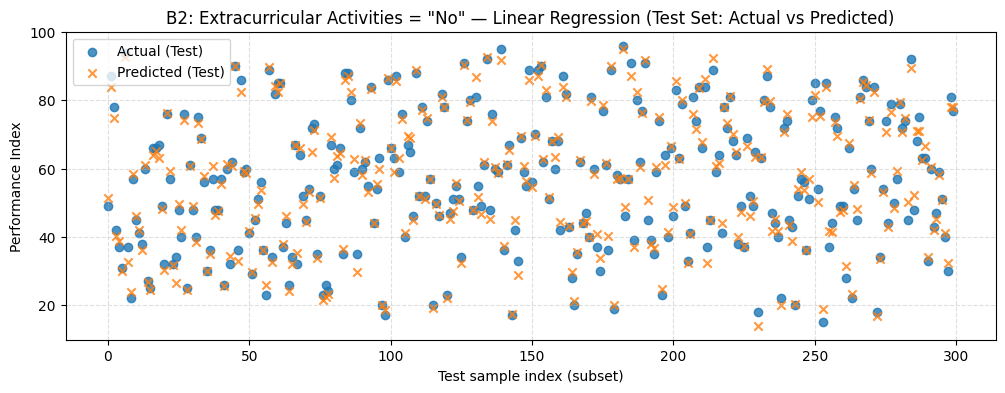


Scenario: B2: Extracurricular Activities = "No"
Model: Polynomial Regression (degree=2)

--- Fitted Model Equation (Top Terms) ---
Performance Index = -33.1963 (+2.7800) * Hours Studied (+1.0268) * Previous Scores (+0.2142) * Sample Question Papers Practiced (+0.2062) * Sleep Hours (+0.0189) * Hours Studied Sleep Hours (+0.0066) * Sleep Hours Sample Question Papers Practiced (-0.0050) * Hours Studied^2 (+0.0038) * Sleep Hours^2 (-0.0026) * Hours Studied Sample Question Papers Practiced (+0.0016) * Previous Scores Sleep Hours (+0.0012) * Sample Question Papers Practiced^2 (-0.0008) * Previous Scores Sample Question Papers Practiced (-0.0002) * Hours Studied Previous Scores (-0.0001) * Previous Scores^2


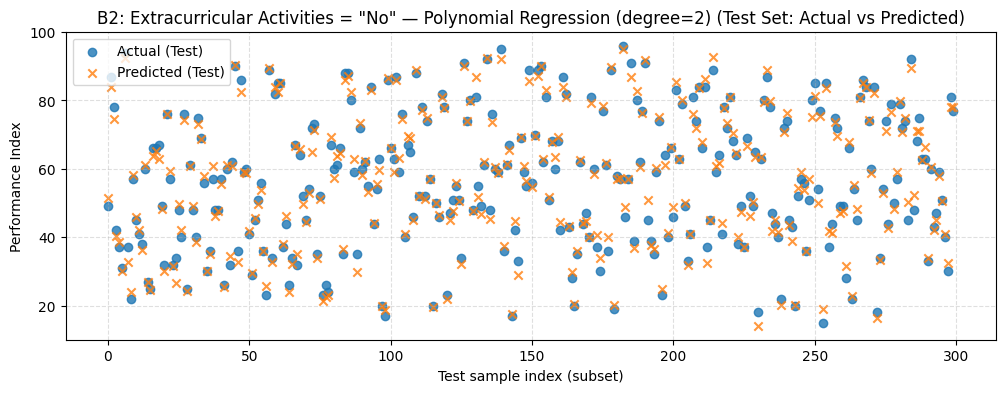


Scenario: B2: Extracurricular Activities = "No"
Model: Polynomial Regression (degree=3)

--- Fitted Model Equation (Top Terms) ---
Performance Index = -37.3691 (+3.2561) * Hours Studied (+1.1740) * Previous Scores (+0.7659) * Sleep Hours (-0.6481) * Sample Question Papers Practiced (+0.1563) * Sleep Hours Sample Question Papers Practiced (-0.0996) * Sleep Hours^2 (+0.0987) * Sample Question Papers Practiced^2 (+0.0594) * Hours Studied Sleep Hours (-0.0476) * Hours Studied Sample Question Papers Practiced (-0.0139) * Hours Studied Previous Scores (-0.0129) * Hours Studied^2 (-0.0085) * Previous Scores Sleep Hours (+0.0067) * Sleep Hours^3 (-0.0054) * Sleep Hours^2 Sample Question Papers Practiced (-0.0046) * Sample Question Papers Practiced^3
(Showing top 15 terms out of 34 total terms.)


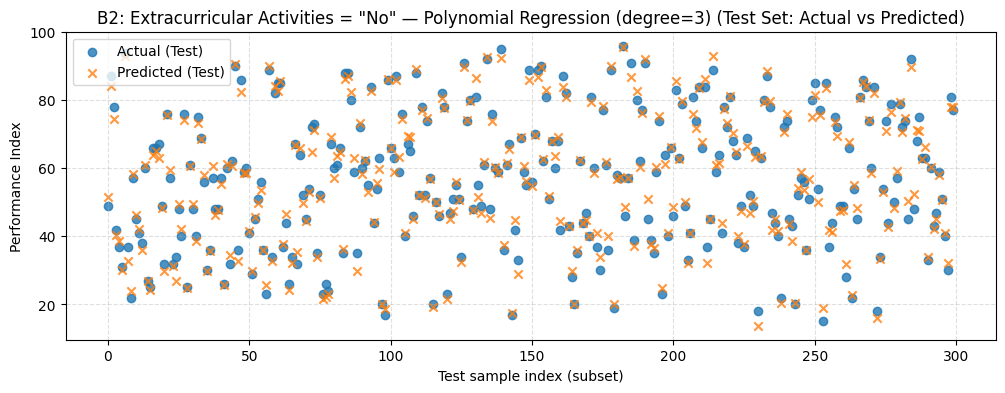


Scenario: B2: Extracurricular Activities = "No"
Model: Polynomial Regression (degree=4)

--- Fitted Model Equation (Top Terms) ---
Performance Index = -77.4328 (+25.5800) * Sleep Hours (-4.8938) * Sleep Hours^2 (+3.4055) * Hours Studied (-3.0045) * Sample Question Papers Practiced (+1.4413) * Previous Scores (+0.4080) * Sleep Hours^3 (-0.2220) * Previous Scores Sleep Hours (+0.2219) * Sample Question Papers Practiced^2 (+0.1787) * Hours Studied^2 (+0.1245) * Previous Scores Sample Question Papers Practiced (-0.1244) * Hours Studied Sample Question Papers Practiced (+0.0604) * Hours Studied Sleep Hours (-0.0586) * Sleep Hours Sample Question Papers Practiced (-0.0429) * Hours Studied Previous Scores (+0.0395) * Sleep Hours Sample Question Papers Practiced^2
(Showing top 15 terms out of 69 total terms.)


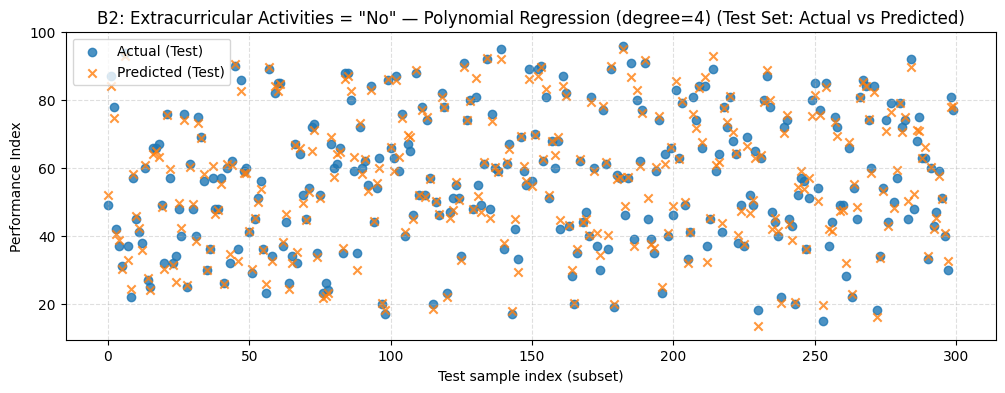

,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,"B1: Extracurricular Activities = ""Yes""",Linear Regression,4.160066,1.621028,0.988746,3.997709,1.569291,0.989314,3463,1485
1,"B1: Extracurricular Activities = ""Yes""",Polynomial Regression (degree=2),4.151543,1.617525,0.988769,4.001311,1.570784,0.989304,3463,1485
2,"B1: Extracurricular Activities = ""Yes""",Polynomial Regression (degree=3),4.114627,1.613711,0.988869,4.049256,1.582117,0.989176,3463,1485
3,"B1: Extracurricular Activities = ""Yes""",Polynomial Regression (degree=4),4.059438,1.601483,0.989018,4.136526,1.601102,0.988943,3463,1485
4,"B2: Extracurricular Activities = ""No""",Linear Regression,4.146587,1.619892,0.988619,4.296245,1.651313,0.988459,3536,1516
5,"B2: Extracurricular Activities = ""No""",Polynomial Regression (degree=2),4.132707,1.616750,0.988657,4.301090,1.650720,0.988446,3536,1516
6,"B2: Extracurricular Activities = ""No""",Polynomial Regression (degree=3),4.107659,1.612307,0.988726,4.319822,1.652574,0.988396,3536,1516
7,"B2: Extracurricular Activities = ""No""",Polynomial Regression (degree=4),4.076977,1.603788,0.988810,4.365867,1.660905,0.988272,3536,1516


In [ ]:

# ============================================================
# Scenario B: Separate models for Yes and No groups
# ============================================================

extra_norm = df[EXTRA_COL].astype(str).str.strip().str.lower()

df_yes = df[extra_norm == "yes"].copy().drop(columns=[EXTRA_COL])
df_no  = df[extra_norm == "no"].copy().drop(columns=[EXTRA_COL])

results_B_yes = run_models_and_evaluate(
    df_yes,
    scenario_name='B1: Extracurricular Activities = "Yes"',
    degrees=(1, 2, 3, 4),
    show_equation=True,
    show_plots=True,
    top_k_terms=15
)

results_B_no = run_models_and_evaluate(
    df_no,
    scenario_name='B2: Extracurricular Activities = "No"',
    degrees=(1, 2, 3, 4),
    show_equation=True,
    show_plots=True,
    top_k_terms=15
)

results_B = pd.concat([results_B_yes, results_B_no], ignore_index=True)
display(results_B)


## Scenario C — One-hot encode `Extracurricular Activities` and train models

In this scenario, we **keep the extracurricular information**, but we convert it into a **numerical form** that regression models can use.

Since `Extracurricular Activities` is a **categorical feature** (`"Yes"` or `"No"`), we cannot directly feed it into a linear regression model.  
So we apply **one-hot encoding**.

---

### What one-hot encoding does
Instead of storing `"Yes"` / `"No"` as text, we create two new binary (0/1) columns:

- **`Extra_Yes`** = 1 if the student has extracurricular activities, otherwise 0  
- **`Extra_No`**  = 1 if the student does not have extracurricular activities, otherwise 0  

This gives a safe and standard numeric representation:

- `"Yes"` → `[Extra_Yes, Extra_No] = [1, 0]`
- `"No"`  → `[Extra_Yes, Extra_No] = [0, 1]`

---

### What the code does
- Makes a copy of the original dataset (`df_encoded`)
- Cleans the `Extracurricular Activities` values (strip spaces + lowercase)
- Creates the two one-hot encoded columns: `Extra_Yes` and `Extra_No`
- Drops the original categorical column
- Trains and evaluates the same four models using a 70/30 train-test split:
  - **Linear Regression**
  - **Polynomial Regression** (degree **2**, **3**, **4**)
- Prints:
  - fitted model equation (top terms)
  - test-set scatter plot (Actual vs Predicted)
  - train/test metrics (MSE, MAE, R²)

✅ This scenario helps us test whether including extracurricular activity information as an additional feature improves prediction performance.




Scenario: C: One-hot encoded Extracurricular Activities
Model: Linear Regression

--- Fitted Model Equation (Top Terms) ---
Performance Index = -33.5457 (+2.8590) * Hours Studied (+1.0155) * Previous Scores (+0.4797) * Sleep Hours (+0.2909) * Extra_Yes (-0.2909) * Extra_No (+0.1904) * Sample Question Papers Practiced


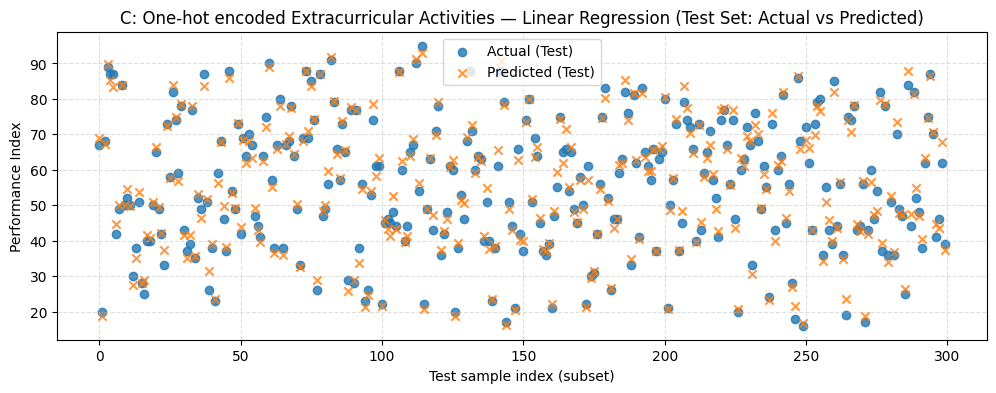


Scenario: C: One-hot encoded Extracurricular Activities
Model: Polynomial Regression (degree=2)

--- Fitted Model Equation (Top Terms) ---
Performance Index = -32.5481 (+1.8666) * Hours Studied (+0.9467) * Hours Studied Extra_Yes (+0.9200) * Hours Studied Extra_No (+0.6845) * Previous Scores (+0.3428) * Previous Scores Extra_No (+0.3417) * Previous Scores Extra_Yes (+0.1299) * Extra_Yes (+0.1299) * Extra_Yes^2 (-0.1299) * Extra_No^2 (-0.1299) * Extra_No (+0.0947) * Sample Question Papers Practiced (+0.0753) * Sleep Hours (+0.0504) * Sample Question Papers Practiced Extra_No (+0.0443) * Sample Question Papers Practiced Extra_Yes (+0.0405) * Sleep Hours Extra_Yes
(Showing top 15 terms out of 27 total terms.)


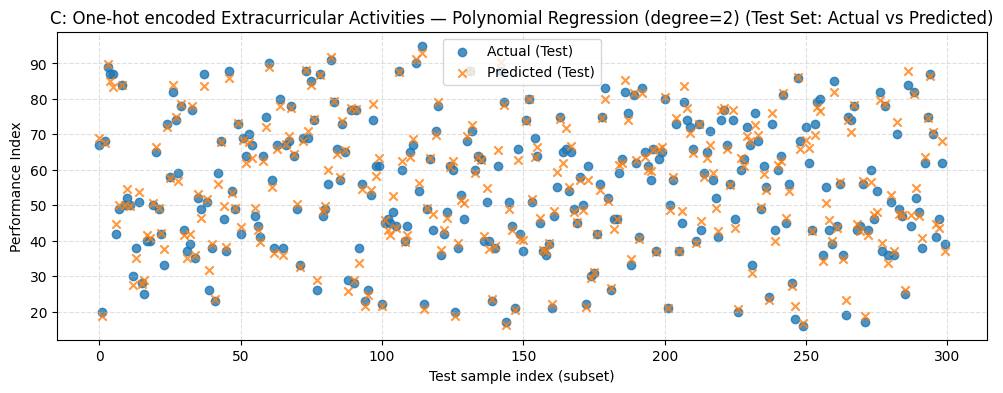


Scenario: C: One-hot encoded Extracurricular Activities
Model: Polynomial Regression (degree=3)

--- Fitted Model Equation (Top Terms) ---
Performance Index = -41.2191 (+1.5272) * Hours Studied (+0.7689) * Hours Studied Extra_Yes (+0.7689) * Hours Studied Extra_Yes^2 (+0.7588) * Sleep Hours (+0.7583) * Hours Studied Extra_No (+0.7583) * Hours Studied Extra_No^2 (+0.6406) * Previous Scores (+0.4740) * Sleep Hours Extra_Yes (+0.4740) * Sleep Hours Extra_Yes^2 (+0.3229) * Previous Scores Extra_Yes (+0.3229) * Previous Scores Extra_Yes^2 (+0.3177) * Previous Scores Extra_No (+0.3177) * Previous Scores Extra_No^2 (+0.2848) * Sleep Hours Extra_No^2 (+0.2848) * Sleep Hours Extra_No
(Showing top 15 terms out of 83 total terms.)


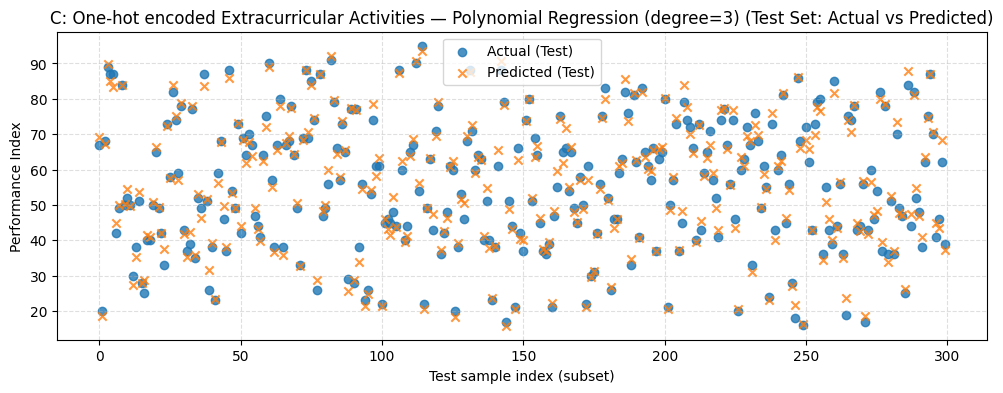


Scenario: C: One-hot encoded Extracurricular Activities
Model: Polynomial Regression (degree=4)

--- Fitted Model Equation (Top Terms) ---
Performance Index = -50.6492 (+2.4270) * Sleep Hours (+1.9695) * Sleep Hours Extra_Yes (+1.9695) * Sleep Hours Extra_Yes^2 (+1.9695) * Sleep Hours Extra_Yes^3 (+1.5499) * Hours Studied (+0.9287) * Hours Studied Extra_Yes (+0.9287) * Hours Studied Extra_Yes^2 (+0.9287) * Hours Studied Extra_Yes^3 (+0.7885) * Extra_No (-0.7885) * Extra_Yes (+0.7885) * Extra_No^2 (-0.7885) * Extra_Yes^3 (-0.7885) * Extra_Yes^4 (+0.7885) * Extra_No^4 (+0.7885) * Extra_No^3
(Showing top 15 terms out of 209 total terms.)


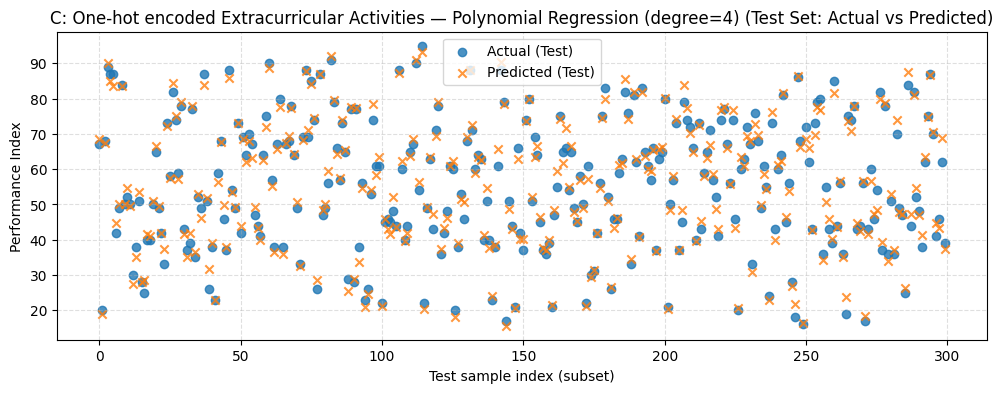

,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,C: One-hot encoded Extracurricular Activities,Linear Regression,4.193474,1.622103,0.988622,4.066564,1.609044,0.989011,7000,3000
1,C: One-hot encoded Extracurricular Activities,Polynomial Regression (degree=2),4.185494,1.620678,0.988644,4.075205,1.609750,0.988988,7000,3000
2,C: One-hot encoded Extracurricular Activities,Polynomial Regression (degree=3),4.168377,1.616565,0.988690,4.074670,1.608008,0.988989,7000,3000
3,C: One-hot encoded Extracurricular Activities,Polynomial Regression (degree=4),4.139630,1.610334,0.988768,4.115773,1.616516,0.988878,7000,3000


In [ ]:

# ============================================================
# Scenario C: One-hot encode extracurricular activities
# ============================================================

df_encoded = df.copy()

extra_norm = df_encoded[EXTRA_COL].astype(str).str.strip().str.lower()
df_encoded["Extra_Yes"] = (extra_norm == "yes").astype(int)
df_encoded["Extra_No"]  = (extra_norm == "no").astype(int)

df_encoded = df_encoded.drop(columns=[EXTRA_COL])

results_C = run_models_and_evaluate(
    df_encoded,
    scenario_name="C: One-hot encoded Extracurricular Activities",
    degrees=(1, 2, 3, 4),
    show_equation=True,
    show_plots=True,
    top_k_terms=15
)

display(results_C)



# Final Comparison Table

All results combined into a single table.


In [ ]:

# ============================================================
# Combine results from all scenarios
# ============================================================

all_results = pd.concat([results_A, results_B, results_C], ignore_index=True)
all_results = all_results.sort_values(by=["Scenario", "Model"]).reset_index(drop=True)

display(all_results)


,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,A: Remove Extracurricular Activities,Linear Regression,4.277996,1.641751,0.988393,4.181380,1.630177,0.988701,7000,3000
1,A: Remove Extracurricular Activities,Polynomial Regression (degree=2),4.272026,1.640938,0.988409,4.188852,1.630133,0.988681,7000,3000
2,A: Remove Extracurricular Activities,Polynomial Regression (degree=3),4.257813,1.638355,0.988448,4.184446,1.627886,0.988693,7000,3000
3,A: Remove Extracurricular Activities,Polynomial Regression (degree=4),4.242087,1.635859,0.988490,4.208458,1.632857,0.988628,7000,3000
4,"B1: Extracurricular Activities = ""Yes""",Linear Regression,4.160066,1.621028,0.988746,3.997709,1.569291,0.989314,3463,1485
5,"B1: Extracurricular Activities = ""Yes""",Polynomial Regression (degree=2),4.151543,1.617525,0.988769,4.001311,1.570784,0.989304,3463,1485
6,"B1: Extracurricular Activities = ""Yes""",Polynomial Regression (degree=3),4.114627,1.613711,0.988869,4.049256,1.582117,0.989176,3463,1485
7,"B1: Extracurricular Activities = ""Yes""",Polynomial Regression (degree=4),4.059438,1.601483,0.989018,4.136526,1.601102,0.988943,3463,1485
8,"B2: Extracurricular Activities = ""No""",Linear Regression,4.146587,1.619892,0.988619,4.296245,1.651313,0.988459,3536,1516
9,"B2: Extracurricular Activities = ""No""",Polynomial Regression (degree=2),4.132707,1.616750,0.988657,4.301090,1.650720,0.988446,3536,1516


# In-Class Activity — Thursday, January 15

**Topic:** Linear vs Polynomial Regression and Feature Encoding  
**Instructions:** Answer the questions below using the results from today’s in-class notebook.  
Write **brief answers** (**1–4 sentences each is enough**).

---

## ✅ Submission (Required)

- Write or type your answers and submit them as a **single PDF** via **Canvas**.
- You may submit either:
  - **Handwritten** answers (clearly written), scanned to PDF, or  
  - **Typed** answers (Word / LaTeX / Google Docs), exported to PDF.
- Make sure your PDF includes your **name** and **UW Student ID**.

---

## Activity Questions (5 Parts)

### (1) Best Model Selection (Test Performance)
From your results table, which model (**Linear / Poly-2 / Poly-3 / Poly-4**) gives the **best Test R²** in **Scenario A** (dropping Extracurricular Activities)?  
✅ Report the **Test R² value**, and briefly explain what it means.

---

### (2) Effect of Polynomial Degree
Does increasing the polynomial degree always improve **test performance**?  
✅ Support your answer using at least **one metric trend** (example: Test MSE or Test R²) from your results.

---

### (3) Did “Extracurricular Activities” Help?
Compare:
- **Scenario A:** Drop Extracurricular Activities  
- **Scenario C:** One-hot encode Extracurricular Activities  

Did including extracurricular information improve the model’s **test performance**?  
✅ Justify your answer using **Test MSE / Test MAE / Test R²**.

---

### (4) Separate Models vs One Combined Model
Compare:
- **Scenario B:** Separate models for `Extracurricular Activities = Yes` and `No`  
- **Scenario C:** One combined model with one-hot encoded extracurricular features  

Which approach appears to generalize better on the **test set**, and why?  
✅ Use test metrics to support your claim.

---

### (5) Encoding a Categorical Feature: 0/1 vs One-Hot Vectors
The feature **Extracurricular Activities** is categorical with two values: **Yes** and **No**.

Two possible encodings are:

- **Binary encoding:** No → `0`, Yes → `1`
- **One-hot encoding:** Yes → `[1, 0]`, No → `[0, 1]`

**Which encoding is more appropriate for regression models and why?**  
✅ In your answer, comment on whether binary encoding introduces an *artificial ordering* or *distance* between categories, and why one-hot encoding can avoid that.



